# ARCH

See [here](https://arch.readthedocs.io/en/latest/univariate/forecasting.html) for some documentation. These models seem to be souped up versions of some of the time series analysis models introduced in the Erdos data science boot camp.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
plt.rc("figure", figsize=(16, 6))
plt.rc("savefig", dpi=90)
plt.rc("font", family="sans-serif")
plt.rc("font", size=14)

In [2]:
import sys

import numpy as np
import pandas as pd

import arch.data.sp500
from arch import arch_model

In [3]:
data = arch.data.sp500.load() # goes till 2018
market = data["Adj Close"]
returns = 100 * market.pct_change().dropna()

In [5]:
arch_model?

Signature:
arch_model(
    y: Union[numpy.ndarray, pandas.core.frame.DataFrame, pandas.core.series.Series, NoneType],
    x: Union[numpy.ndarray, pandas.core.frame.DataFrame, NoneType] = None,
    mean: Literal['Constant', 'Zero', 'LS', 'AR', 'ARX', 'HAR', 'HARX', 'constant', 'zero'] = 'Constant',
    lags: Union[int, list[int], numpy.ndarray[Any, numpy.dtype[numpy.int32]], numpy.ndarray[Any, numpy.dtype[numpy.longlong]], NoneType] = 0,
    vol: Literal['GARCH', 'ARCH', 'EGARCH', 'FIGARCH', 'APARCH', 'HARCH'] = 'GARCH',
    p: Union[int, list[int]] = 1,
    o: int = 0,
    q: int = 1,
    power: float = 2.0,
    dist: Literal['normal', 'gaussian', 't', 'studentst', 'skewstudent', 'skewt', 'ged', 'generalized error'] = 'normal',
    hold_back: Optional[int] = None,
    rescale: Optional[bool] = None,
) -> arch.univariate.mean.HARX
Docstring:
Initialization of common ARCH model specifications

Parameters
----------
y : ndarray, Series, None
    The dependent variable
x : ndarray, DataFra

In [4]:
am = arch_model(returns, vol="Garch", p=1, o=0, q=1, dist="Normal") # some hyperparameters
res = am.fit(update_freq=5)

Iteration:      5,   Func. Count:     35,   Neg. LLF: 6970.2765831170655
Iteration:     10,   Func. Count:     63,   Neg. LLF: 6936.718477482658
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6936.718476988985
            Iterations: 11
            Function evaluations: 68
            Gradient evaluations: 11


In [9]:
forecasts = res.forecast(horizon = 5) # set the number of steps ahead we want to forecast

`mean` - The forecast means

`residual_variance` - The forecast residual variances, that is $E_t[\epsilon^2_{t+h}]$

`variance` - The forecast variance of the process, $E_t[r^2_{t+h}]$. The variance will differ from the residual variance whenever the model has mean dynamics, e.g., in an AR process.

`simulations` - An object that contains detailed information about the simulations used to generate forecasts. Only used if the forecast method is set to `simulation` or `bootstrap`. If using `analytical` (the default), this is `None`.

In [10]:
print(forecasts.mean.iloc[-3:])
print(forecasts.residual_variance.iloc[-3:])
print(forecasts.variance.iloc[-3:])

                 h.1       h.2       h.3       h.4       h.5
Date                                                        
2018-12-31  0.056353  0.056353  0.056353  0.056353  0.056353
                h.1       h.2       h.3       h.4       h.5
Date                                                       
2018-12-31  3.59647  3.568502  3.540887  3.513621  3.486701
                h.1       h.2       h.3       h.4       h.5
Date                                                       
2018-12-31  3.59647  3.568502  3.540887  3.513621  3.486701


Rolling window forecasting

In [11]:
index = returns.index
start_loc = 0
end_loc = np.where(index >= "2010-1-1")[0].min()
forecasts = {}
for i in range(20): # how many days ahead
    sys.stdout.write(".")
    sys.stdout.flush()
    res = am.fit(first_obs=i, last_obs=i + end_loc, disp="off")
    temp = res.forecast(horizon=3).variance
    fcast = temp.iloc[0]
    forecasts[fcast.name] = fcast
print()
print(pd.DataFrame(forecasts).T)

....................
                 h.1       h.2       h.3
2009-12-31  0.615314  0.621743  0.628133
2010-01-04  0.751747  0.757343  0.762905
2010-01-05  0.710453  0.716315  0.722142
2010-01-06  0.666244  0.672346  0.678411
2010-01-07  0.634424  0.640706  0.646949
2010-01-08  0.600109  0.606595  0.613040
2010-01-11  0.565514  0.572212  0.578869
2010-01-12  0.599561  0.606051  0.612501
2010-01-13  0.608309  0.614748  0.621148
2010-01-14  0.575065  0.581756  0.588406
2010-01-15  0.629890  0.636245  0.642561
2010-01-19  0.695074  0.701042  0.706974
2010-01-20  0.737154  0.742908  0.748627
2010-01-21  0.954167  0.958725  0.963255
2010-01-22  1.253453  1.256401  1.259332
2010-01-25  1.178691  1.182043  1.185374
2010-01-26  1.112205  1.115886  1.119545
2010-01-27  1.051295  1.055327  1.059335
2010-01-28  1.085678  1.089512  1.093324
2010-01-29  1.085786  1.089593  1.093378


In [13]:
# TARCH specification
am = arch_model(returns, vol="GARCH", power=2.0, p=1, o=1, q=1)
res = am.fit(update_freq=5)
forecasts = res.forecast()
print(forecasts.variance.iloc[-1])


Iteration:      5,   Func. Count:     40,   Neg. LLF: 6846.496611626368
Iteration:     10,   Func. Count:     75,   Neg. LLF: 6822.883179368218
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6822.882823437632
            Iterations: 13
            Function evaluations: 93
            Gradient evaluations: 13
h.1    3.010188
Name: 2018-12-31 00:00:00, dtype: float64


(16804.0, 17165.0)

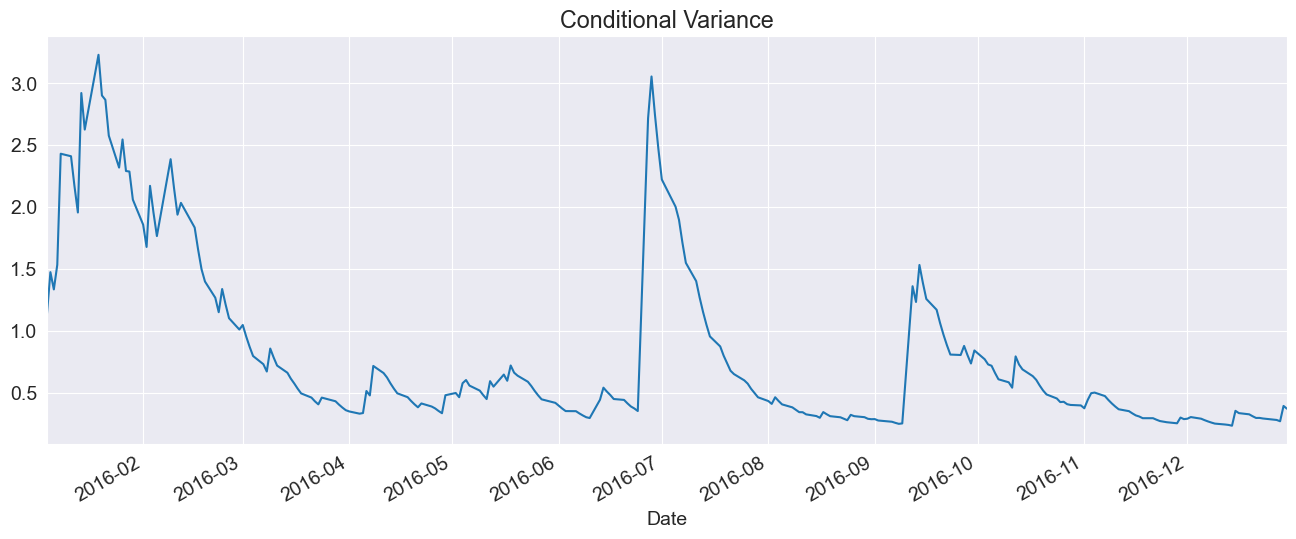

In [14]:
fig, ax = plt.subplots(1, 1)
var_2016 = res.conditional_volatility["2016"] ** 2.0
subplot = var_2016.plot(ax=ax, title="Conditional Variance")
subplot.set_xlim(var_2016.index[0], var_2016.index[-1])
